# Importing necessary libraries

In [1]:
!pip install pandas transformers
!pip install gensim emoji nltk tqdm seaborn torch torchsummary -q


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [2]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel, BertModel,BertTokenizer,AutoConfig, TFAutoModel
import os
import gensim
import transformers
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import gc
import os
import tensorflow as tf
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# We need to preprocess our data before tokenizing them, here nltk is used.

In [12]:
import nltk
import emoji
import re

nltk.download(["stopwords", "punkt", "wordnet", "averaged_perceptron_tagger"])

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [13]:


stopwords = nltk.corpus.stopwords.words("english")
lemmatizer = nltk.stem.WordNetLemmatizer()

def nltk_pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return 'a'
    elif nltk_tag.startswith('V'):
        return 'v'
    elif nltk_tag.startswith('N'):
        return 'n'
    elif nltk_tag.startswith('R'):
        return 'r'
    else:
        return 'n'

def preprocess_data(text: str):
    """
    Preprocessing steps are as follows:
    1. lowercase the text
    2. remove punctuation
    3. remove numbers
    4. remove urls
    5. remove usernames
    6. remove extra spaces
    7. convert emojis to text
    8. remove non-word characters
    9. lemmatization and tokenization of the text
    10. remove stopwords
    :param text: str
    :return: tokens: list[str]
    """
    

    text = text.lower()
  
    text = re.sub(r'\d+', '', text)
    
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    text = re.sub(r'@\w+', '', text)
    
    text = re.sub(r'\s+', ' ', text).strip()
    
    text = emoji.demojize(text)

    text = re.sub(r'\W+', ' ', text)

    tokens = nltk.word_tokenize(text)

    tokens = [lemmatizer.lemmatize(token, nltk_pos_tagger(tag)) for token, tag in nltk.pos_tag(tokens)]

    tokens = [token for token in tokens if token not in stopwords]
    
    cleaned_text = ' '.join(tokens)
    
    return cleaned_text

In [14]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [20]:

def process_csv(input_path, output_path):
    df = pd.read_csv(input_path)
    df['preprocessed_tweet'] = df['tweet'].apply(lambda x: preprocess_data(str(x)))
    df.to_csv(output_path, index=False)

train_input_path = '/kaggle/input/fake-news/Train.csv'
train_output_path = '/kaggle/working/cleaned_train.csv'
test_input_path = '/kaggle/input/true-test/TestTrue.csv'
test_output_path = '/kaggle/working/cleaned_true_test.csv'
valid_input_path = '/kaggle/input/fake-news/Val.csv'
valid_output_path = '/kaggle/working/cleaned_val.csv'

process_csv(train_input_path, train_output_path)
process_csv(test_input_path, test_output_path)
process_csv(valid_input_path, valid_output_path)

In [17]:
cleaned_file_paths = [
    '/kaggle/working/cleaned_true_test.csv',
    '/kaggle/working/cleaned_train.csv',
    '/kaggle/working/cleaned_val.csv'
]

In [3]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = TFAutoModel.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

# Preparing the dataset

In [3]:

def load_and_preprocess_data(file_path, tokenizer):
    df = pd.read_csv(file_path)
    texts = df['preprocessed_tweet'].tolist()
    labels = df['label'].tolist()
    
    label_map = {'real': 1, 'fake': 0}
    labels = [label_map[label] for label in labels]
    
    tokenized_inputs = tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors='tf')
    
    labels = tf.convert_to_tensor(labels, dtype=tf.float32)
    
    return tokenized_inputs, labels



In [7]:

train_inputs, train_labels = load_and_preprocess_data('/kaggle/working/cleaned_train.csv', tokenizer)
val_inputs, val_labels = load_and_preprocess_data('/kaggle/working/cleaned_val.csv', tokenizer)
test_inputs, test_labels = load_and_preprocess_data('/kaggle/working/cleaned_true_test.csv', tokenizer)

def create_dataset(inputs, labels, batch_size=4):
    dataset = tf.data.Dataset.from_tensor_slices(({
        'input_ids': inputs['input_ids'],
        'attention_mask': inputs['attention_mask'],
        'token_type_ids': inputs.get('token_type_ids', tf.zeros_like(inputs['input_ids']))  
    }, labels))
    dataset = dataset.shuffle(1000).batch(batch_size)
    return dataset

train_dataset = create_dataset(train_inputs, train_labels)
val_dataset = create_dataset(val_inputs, val_labels)
test_dataset = create_dataset(test_inputs, test_labels)

In [13]:
train_dataset

<_BatchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None), 'token_type_ids': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None)}, TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

# Now we fine-tune bert + dense layer for classification task

In [18]:
class BERTForClassification(tf.keras.Model):
    
    def __init__(self, bert_model, num_classes):
        super().__init__()
        self.bert = bert_model
        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.dropout = tf.keras.layers.Dropout(0.1)
        self.fc = tf.keras.layers.Dense(num_classes, activation='sigmoid',kernel_initializer='glorot_uniform')
        
    def call(self, inputs, training = False):
        x = self.bert(inputs)[1]
        x = self.batch_norm(x, training=training)
        x = self.dropout(x, training=training)
        return self.fc(x)
    
classifier = BERTForClassification(model, num_classes=1)

classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=3, 
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.2, 
        patience=1, 
        min_lr=1e-7
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='/kaggle/working/dense128', 
        monitor='val_loss', 
        save_best_only=True
    )
]


history1 = classifier.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=3,
    callbacks = callbacks,
    shuffle = True
)

Epoch 1/3
1605/1605 [==============================] - 387s 202ms/step - loss: 0.4229 - accuracy: 0.8198 - val_loss: 0.2330 - val_accuracy: 0.9084 - lr: 2.0000e-05
Epoch 2/3
1605/1605 [==============================] - 231s 144ms/step - loss: 0.3029 - accuracy: 0.8812 - val_loss: 0.2568 - val_accuracy: 0.9079 - lr: 2.0000e-05
Epoch 3/3
1605/1605 [==============================] - 308s 192ms/step - loss: 0.2010 - accuracy: 0.9165 - val_loss: 0.2322 - val_accuracy: 0.9430 - lr: 4.0000e-06


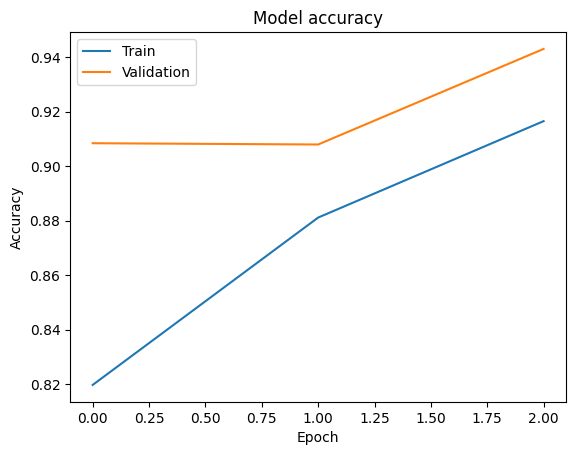

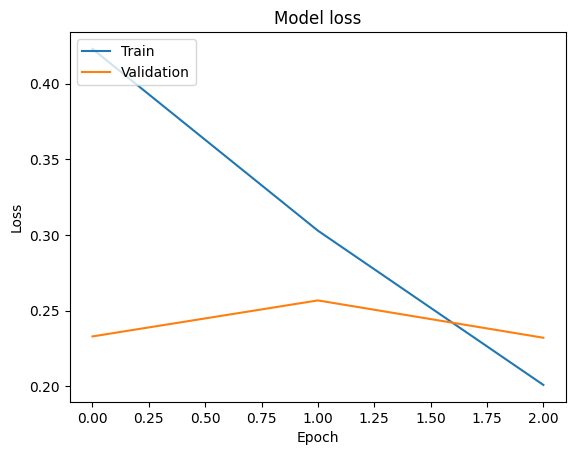

In [20]:
import matplotlib.pyplot as plt

plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

data = pd.read_csv('/kaggle/working/cleaned_true_test.csv')

true_labels = data['label']
true_labels_numeric = [1 if label == 'real' else 0 for label in true_labels]


In [23]:
tokenized_texts = tokenizer(list(data['preprocessed_tweet']), padding=True, truncation=True, max_length=128, return_tensors='tf')

input_ids = tf.convert_to_tensor(tokenized_texts['input_ids'])
attention_mask = tf.convert_to_tensor(tokenized_texts['attention_mask'])
token_type_ids = tf.convert_to_tensor(tokenized_texts['token_type_ids'])

predictions = classifier.predict({
    'input_ids': input_ids,
    'token_type_ids': token_type_ids,
    'attention_mask': attention_mask
})

pred_labels = predictions > 0.5 

accuracy = accuracy_score(true_labels_numeric, pred_labels)
precision = precision_score(true_labels_numeric, pred_labels)
recall = recall_score(true_labels_numeric, pred_labels)
f1 = f1_score(true_labels_numeric, pred_labels)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)



67/67 [==============================] - 29s 265ms/step
Accuracy: 0.9401869158878504
Precision: 0.955045871559633
Recall: 0.9294642857142857
F1 Score: 0.9420814479638009


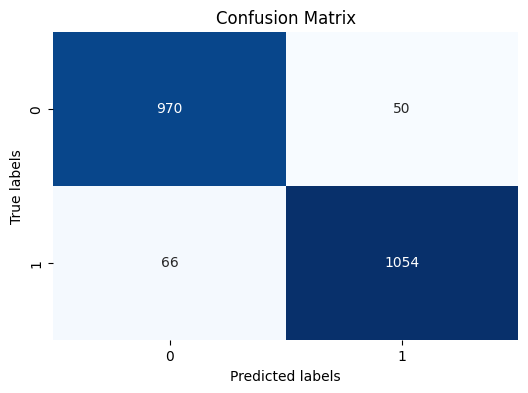

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels_numeric, pred_labels)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [28]:

# custom_objects = {'BERTForClassification': BERTForClassification}

# classifier = tf.keras.models.load_model('/kaggle/working/dense128', custom_objects=custom_objects)


# Now we want to fine-tune bert + BIGRU + dense for classification task

In [9]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = TFAutoModel.from_pretrained("bert-base-uncased")


class BERTForClassificationBIGRU(tf.keras.Model):
    
    def __init__(self, bert_model, num_classes):
        super().__init__()
        self.bert = bert_model
        self.bigru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, kernel_initializer='glorot_uniform', return_sequences=False))
        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.dropout = tf.keras.layers.Dropout(0.1)
        self.fc = tf.keras.layers.Dense(num_classes, activation='sigmoid', kernel_initializer='glorot_uniform')
        
    def call(self, inputs, training=False):
        bert_output = self.bert(inputs)[0]
        
        bigru_output = self.bigru(bert_output)

        x = self.batch_norm(bigru_output, training=training)

        x = self.dropout(x, training=training)

        output = self.fc(x)
        
        
        return output

    
classifier2 = BERTForClassificationBIGRU(model, num_classes=1)

classifier2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy']
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [10]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=3, 
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.2, 
        patience=1, 
        min_lr=1e-7
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='/kaggle/working/GRU128', 
        monitor='val_loss', 
        save_best_only=True
    )
]



history2 = classifier2.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=3,
    callbacks = callbacks,
    shuffle = True
)

Epoch 1/3
1605/1605 [==============================] - 432s 227ms/step - loss: 0.4453 - accuracy: 0.8139 - val_loss: 0.2113 - val_accuracy: 0.9224 - lr: 2.0000e-05
Epoch 2/3
1605/1605 [==============================] - 260s 162ms/step - loss: 0.3254 - accuracy: 0.8668 - val_loss: 0.3805 - val_accuracy: 0.8762 - lr: 2.0000e-05
Epoch 3/3
1605/1605 [==============================] - 346s 216ms/step - loss: 0.2005 - accuracy: 0.9153 - val_loss: 0.1870 - val_accuracy: 0.9491 - lr: 4.0000e-06


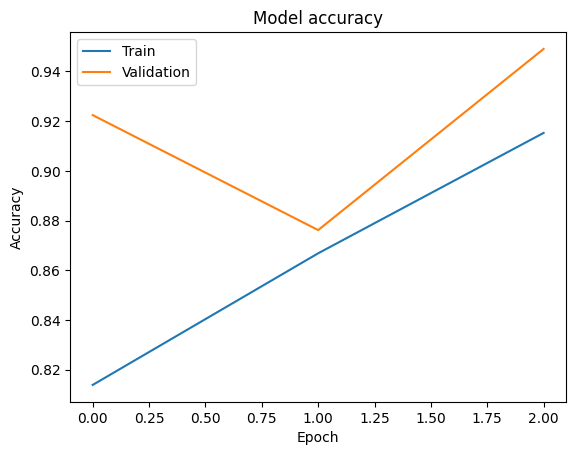

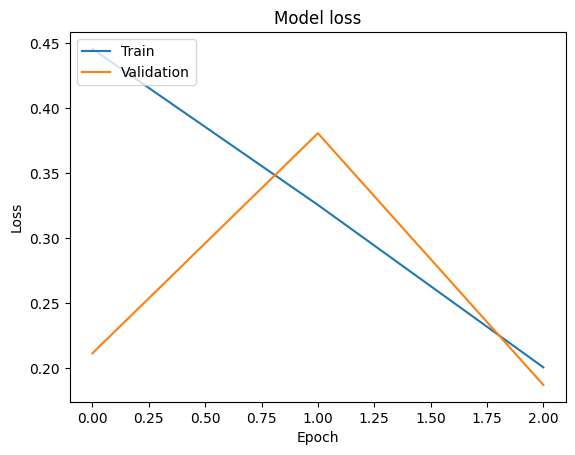

In [11]:

plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [14]:
tokenized_texts = tokenizer(list(data['preprocessed_tweet']), padding=True, truncation=True, max_length=128, return_tensors='tf')

input_ids = tf.convert_to_tensor(tokenized_texts['input_ids'])
attention_mask = tf.convert_to_tensor(tokenized_texts['attention_mask'])
token_type_ids = tf.convert_to_tensor(tokenized_texts['token_type_ids'])


predictions = classifier2.predict({
    'input_ids': input_ids,
    'token_type_ids': token_type_ids,
    'attention_mask': attention_mask
})

pred_labels = predictions > 0.5 

accuracy = accuracy_score(true_labels_numeric, pred_labels)
precision = precision_score(true_labels_numeric, pred_labels)
recall = recall_score(true_labels_numeric, pred_labels)
f1 = f1_score(true_labels_numeric, pred_labels)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


67/67 [==============================] - 32s 293ms/step
Accuracy: 0.9406542056074766
Precision: 0.9576036866359448
Recall: 0.9276785714285715
F1 Score: 0.9424036281179139


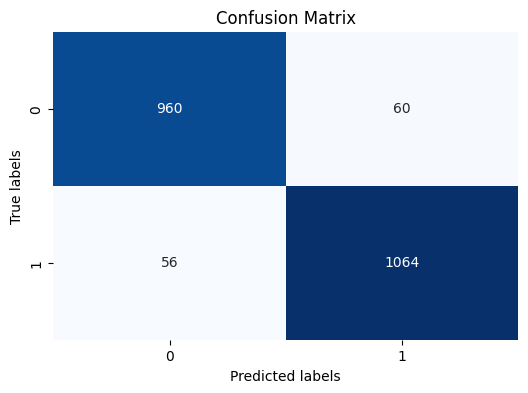

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels_numeric, pred_labels)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [51]:

# custom_objects = {'BERTForClassificationBIGRU': BERTForClassificationBIGRU}

# classifier2 = tf.keras.models.load_model('/kaggle/working/GRU128', custom_objects=custom_objects)


# Now we fine_tune CT-bert + BIGRU + dense. CT-bert is a bert trained on covid19 dataset.

In [50]:
tokenizer = AutoTokenizer.from_pretrained("digitalepidemiologylab/covid-twitter-bert")
model = TFAutoModel.from_pretrained("digitalepidemiologylab/covid-twitter-bert")

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/421 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/1.47G [00:00<?, ?B/s]

Some layers from the model checkpoint at digitalepidemiologylab/covid-twitter-bert were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at digitalepidemiologylab/covid-twitter-bert.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [52]:
train_inputs, train_labels = load_and_preprocess_data('/kaggle/working/cleaned_train.csv', tokenizer)
val_inputs, val_labels = load_and_preprocess_data('/kaggle/working/cleaned_val.csv', tokenizer)

def create_dataset(inputs, labels, batch_size=4):
    dataset = tf.data.Dataset.from_tensor_slices(({
        'input_ids': inputs['input_ids'],
        'attention_mask': inputs['attention_mask'],
        'token_type_ids': inputs.get('token_type_ids', tf.zeros_like(inputs['input_ids']))  
    }, labels))
    dataset = dataset.shuffle(1000).batch(batch_size)
    return dataset

train_dataset = create_dataset(train_inputs, train_labels)
val_dataset = create_dataset(val_inputs, val_labels)

In [53]:
classifier3 = BERTForClassificationBIGRU(model, num_classes=1)

classifier3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [54]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=3, 
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.2, 
        patience=1, 
        min_lr=1e-7
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='/kaggle/working/GRU128CT', 
        monitor='val_loss', 
        save_best_only=True
    )
]


history3 = classifier3.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=3,
    callbacks = callbacks,
    shuffle = True
)

Epoch 1/3
1605/1605 [==============================] - 1111s 610ms/step - loss: 0.2194 - accuracy: 0.9148 - val_loss: 0.1484 - val_accuracy: 0.9407 - lr: 2.0000e-05
Epoch 2/3
1605/1605 [==============================] - 775s 483ms/step - loss: 0.0628 - accuracy: 0.9776 - val_loss: 0.1779 - val_accuracy: 0.9453 - lr: 2.0000e-05
Epoch 3/3
1605/1605 [==============================] - 774s 482ms/step - loss: 0.0130 - accuracy: 0.9958 - val_loss: 0.1908 - val_accuracy: 0.9542 - lr: 4.0000e-06


In [58]:

custom_objects = {'BERTForClassificationBIGRU': BERTForClassificationBIGRU}

GRU128CT_classifier = tf.keras.models.load_model('/kaggle/working/GRU128CT', custom_objects=custom_objects)


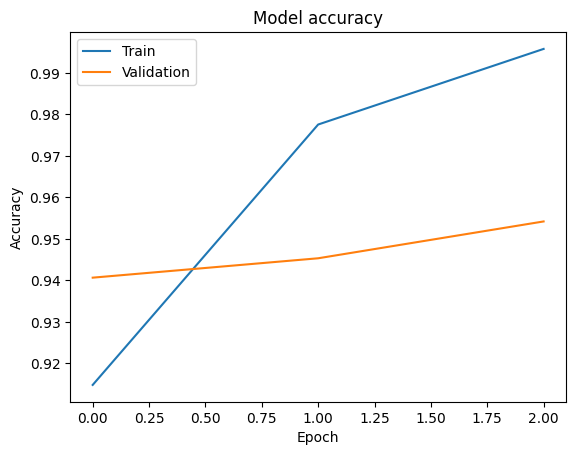

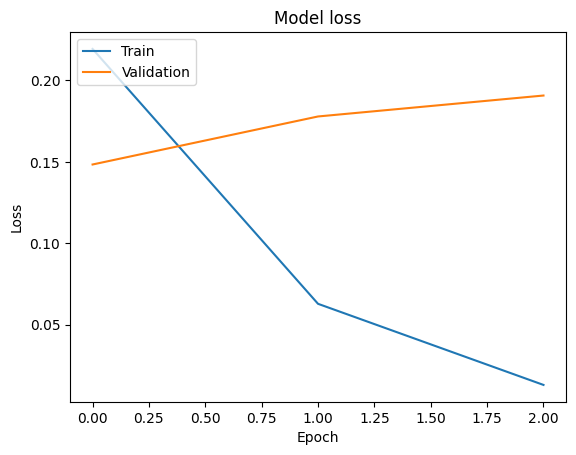

In [55]:

plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [56]:
predictions = classifier3.predict({
    'input_ids': input_ids,
    'token_type_ids': token_type_ids,
    'attention_mask': attention_mask
})

pred_labels = predictions > 0.5  

accuracy = accuracy_score(true_labels_numeric, pred_labels)
precision = precision_score(true_labels_numeric, pred_labels)
recall = recall_score(true_labels_numeric, pred_labels)
f1 = f1_score(true_labels_numeric, pred_labels)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

67/67 [==============================] - 79s 871ms/step
Accuracy: 0.9565420560747664
Precision: 0.9500438212094654
Recall: 0.9678571428571429
F1 Score: 0.9588677576293675


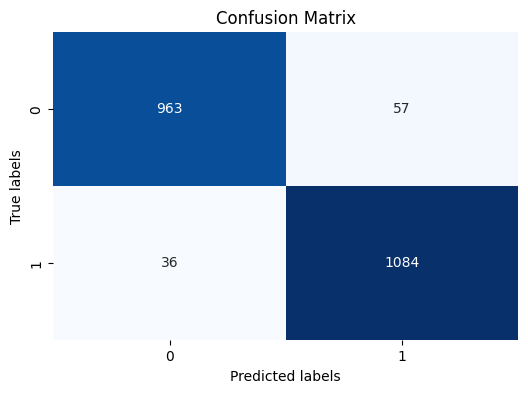

In [57]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels_numeric, pred_labels)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


# Now instead of fine-tuning, we implemment feature-based technique. It is simply freezing the bert and ct-bert models, the rest is same as before.

# here we train freezed bert + dense for classification

In [28]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = TFAutoModel.from_pretrained("bert-base-uncased")

for layer in model.layers[:]:
    if isinstance(layer, transformers.models.bert.modeling_tf_bert.TFBertMainLayer):
        for idx, layer in enumerate(layer.encoder.layer):
            layer.trainable = False
            
            
for layer in model.layers[:]:
    if isinstance(layer, transformers.models.bert.modeling_tf_bert.TFBertMainLayer):
        for idx, layer in enumerate(layer.encoder.layer):
            print(layer, layer.trainable)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

<transformers.models.bert.modeling_tf_bert.TFBertLayer object at 0x788ba4bcec80> False
<transformers.models.bert.modeling_tf_bert.TFBertLayer object at 0x788ba4bcf7c0> False
<transformers.models.bert.modeling_tf_bert.TFBertLayer object at 0x788ba4bb7a90> False
<transformers.models.bert.modeling_tf_bert.TFBertLayer object at 0x788ba4ba14e0> False
<transformers.models.bert.modeling_tf_bert.TFBertLayer object at 0x788ba4b88280> False
<transformers.models.bert.modeling_tf_bert.TFBertLayer object at 0x788ba4b78b50> False
<transformers.models.bert.modeling_tf_bert.TFBertLayer object at 0x788ba4b7b040> False
<transformers.models.bert.modeling_tf_bert.TFBertLayer object at 0x788ba4b6b580> False
<transformers.models.bert.modeling_tf_bert.TFBertLayer object at 0x788ba4b19180> False
<transformers.models.bert.modeling_tf_bert.TFBertLayer object at 0x788ba4b54d90> False
<transformers.models.bert.modeling_tf_bert.TFBertLayer object at 0x788ba4b48520> False
<transformers.models.bert.modeling_tf_bert.

In [59]:

train_inputs, train_labels = load_and_preprocess_data('/kaggle/working/cleaned_train.csv', tokenizer)
val_inputs, val_labels = load_and_preprocess_data('/kaggle/working/cleaned_val.csv', tokenizer)

def create_dataset(inputs, labels, batch_size=4):
    dataset = tf.data.Dataset.from_tensor_slices(({
        'input_ids': inputs['input_ids'],
        'attention_mask': inputs['attention_mask'],
        'token_type_ids': inputs.get('token_type_ids', tf.zeros_like(inputs['input_ids'])) 
    }, labels))
    dataset = dataset.shuffle(1000).batch(batch_size)
    return dataset

train_dataset = create_dataset(train_inputs, train_labels)
val_dataset = create_dataset(val_inputs, val_labels)

In [30]:
class BERTForClassification(tf.keras.Model):
    
    def __init__(self, bert_model, num_classes):
        super().__init__()
        self.bert = bert_model
        self.fc = tf.keras.layers.Dense(num_classes, activation='sigmoid',kernel_initializer='glorot_uniform')
        
    def call(self, inputs):
        x = self.bert(inputs)[1]
        return self.fc(x)
    
    
classifier4 = BERTForClassification(model, num_classes=1)

classifier4.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [61]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=3, 
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.2, 
        patience=1, 
        min_lr=1e-7
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='/kaggle/working/dense128Freeze', 
        monitor='val_loss', 
        save_best_only=True
    )
]


history4 = classifier4.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=3,
    callbacks = callbacks,
    shuffle = True
)

Epoch 1/3
1605/1605 [==============================] - 286s 159ms/step - loss: 0.3726 - accuracy: 0.8441 - val_loss: 0.2720 - val_accuracy: 0.8921 - lr: 2.0000e-05
Epoch 2/3
1605/1605 [==============================] - 239s 149ms/step - loss: 0.2218 - accuracy: 0.9134 - val_loss: 0.2260 - val_accuracy: 0.9112 - lr: 2.0000e-05
Epoch 3/3
1605/1605 [==============================] - 243s 151ms/step - loss: 0.1591 - accuracy: 0.9397 - val_loss: 0.2101 - val_accuracy: 0.9215 - lr: 2.0000e-05


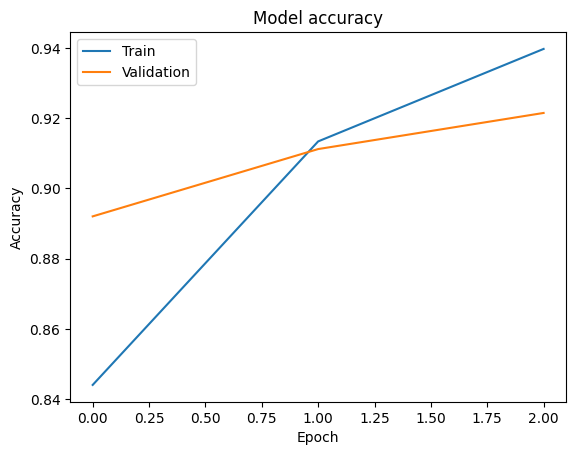

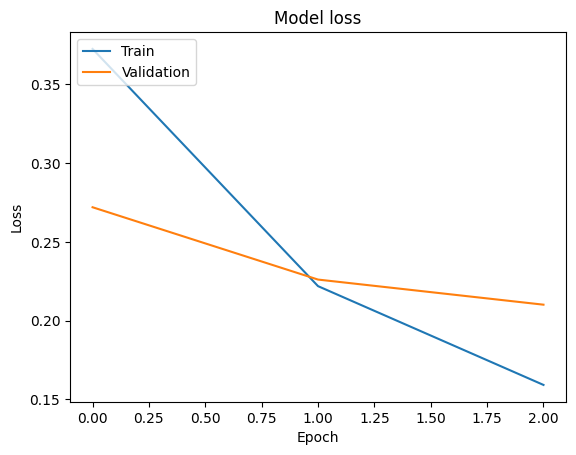

In [62]:

plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [63]:
predictions = classifier4.predict({
    'input_ids': input_ids,
    'token_type_ids': token_type_ids,
    'attention_mask': attention_mask
})

pred_labels = predictions > 0.5  

accuracy = accuracy_score(true_labels_numeric, pred_labels)
precision = precision_score(true_labels_numeric, pred_labels)
recall = recall_score(true_labels_numeric, pred_labels)
f1 = f1_score(true_labels_numeric, pred_labels)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

67/67 [==============================] - 31s 303ms/step
Accuracy: 0.9200934579439253
Precision: 0.9341262580054894
Recall: 0.9116071428571428
F1 Score: 0.9227293267058292


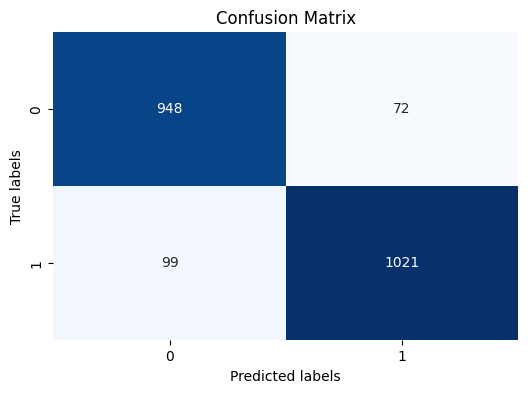

In [64]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels_numeric, pred_labels)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [31]:

custom_objects = {'BERTForClassification': BERTForClassification}

dense128Freeze_classifier = tf.keras.models.load_model('/kaggle/working/dense128Freeze', custom_objects=custom_objects)


In [32]:
import pandas as pd

tokenized_texts = tokenizer(list(data['preprocessed_tweet']), padding=True, truncation=True, max_length=128, return_tensors='tf')

input_ids = tf.convert_to_tensor(tokenized_texts['input_ids'])
attention_mask = tf.convert_to_tensor(tokenized_texts['attention_mask'])
token_type_ids = tf.convert_to_tensor(tokenized_texts['token_type_ids'])

predictions = dense128Freeze_classifier.predict({
    'input_ids': input_ids,
    'token_type_ids': token_type_ids,
    'attention_mask': attention_mask
})
pred_labels = (predictions > 0.5).astype(int).flatten()  
results_df = pd.DataFrame({
    'Tweet': data['tweet'],
    'True Label': true_labels_numeric,
    'Predicted Label': pred_labels
})

wrong_predictions_df = results_df[results_df['True Label'] != results_df['Predicted Label']]
wrong_predictions_df.to_csv('/kaggle/working/wrong_dense128Freeze.csv', index=False)

print(wrong_predictions_df.head(2))

67/67 [==============================] - 20s 269ms/step
                                                Tweet  True Label  \
7   The government should consider bringing in any...           1   
12  🇰🇼 Assistant Undersecretary for Public Health ...           1   

    Predicted Label  
7                 0  
12                0  


# Now we train freezed bert + BIGRU + dense for classification

In [25]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = TFAutoModel.from_pretrained("bert-base-uncased")

for layer in model.layers[:]:
    if isinstance(layer, transformers.models.bert.modeling_tf_bert.TFBertMainLayer):
        for idx, layer in enumerate(layer.encoder.layer):
            layer.trainable = False
            
classifier5 = BERTForClassificationBIGRU(model, num_classes=1)

classifier5.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy']
)            

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [66]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=3, 
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.2, 
        patience=1, 
        min_lr=1e-7
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='/kaggle/working/BIGRU128Freeze', 
        monitor='val_loss', 
        save_best_only=True
    )
]


history5 = classifier5.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=3,
    callbacks = callbacks,
    shuffle = True
)

Epoch 1/3
1605/1605 [==============================] - 316s 175ms/step - loss: 0.3884 - accuracy: 0.8321 - val_loss: 0.2636 - val_accuracy: 0.8944 - lr: 2.0000e-05
Epoch 2/3
1605/1605 [==============================] - 264s 164ms/step - loss: 0.2060 - accuracy: 0.9193 - val_loss: 0.2125 - val_accuracy: 0.9145 - lr: 2.0000e-05
Epoch 3/3
1605/1605 [==============================] - 266s 166ms/step - loss: 0.1440 - accuracy: 0.9445 - val_loss: 0.2020 - val_accuracy: 0.9224 - lr: 2.0000e-05


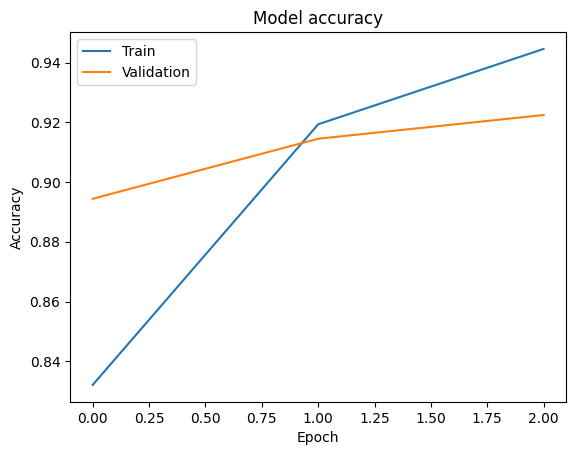

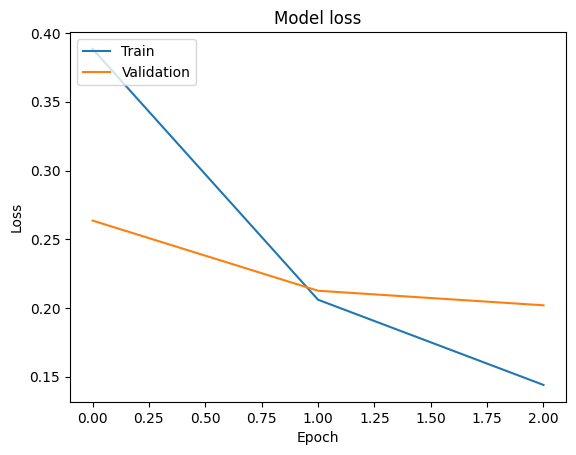

In [67]:

plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [68]:
predictions = classifier5.predict({
    'input_ids': input_ids,
    'token_type_ids': token_type_ids,
    'attention_mask': attention_mask
})

pred_labels = predictions > 0.5 

accuracy = accuracy_score(true_labels_numeric, pred_labels)
precision = precision_score(true_labels_numeric, pred_labels)
recall = recall_score(true_labels_numeric, pred_labels)
f1 = f1_score(true_labels_numeric, pred_labels)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

67/67 [==============================] - 30s 280ms/step
Accuracy: 0.9242990654205607
Precision: 0.9370437956204379
Recall: 0.9169642857142857
F1 Score: 0.9268953068592057


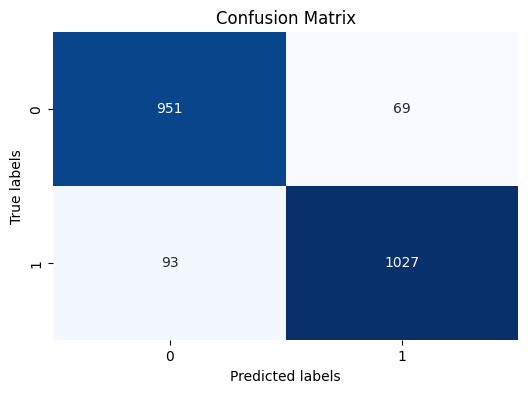

In [69]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels_numeric, pred_labels)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [26]:

custom_objects = {'BERTForClassificationBIGRU': BERTForClassificationBIGRU}

BIGRU128Freeze_classifier = tf.keras.models.load_model('/kaggle/working/BIGRU128Freeze', custom_objects=custom_objects)


In [27]:
import pandas as pd

tokenized_texts = tokenizer(list(data['preprocessed_tweet']), padding=True, truncation=True, max_length=128, return_tensors='tf')

input_ids = tf.convert_to_tensor(tokenized_texts['input_ids'])
attention_mask = tf.convert_to_tensor(tokenized_texts['attention_mask'])
token_type_ids = tf.convert_to_tensor(tokenized_texts['token_type_ids'])

predictions = BIGRU128Freeze_classifier.predict({
    'input_ids': input_ids,
    'token_type_ids': token_type_ids,
    'attention_mask': attention_mask
})
pred_labels = (predictions > 0.5).astype(int).flatten()  
results_df = pd.DataFrame({
    'Tweet': data['tweet'],
    'True Label': true_labels_numeric,
    'Predicted Label': pred_labels
})

wrong_predictions_df = results_df[results_df['True Label'] != results_df['Predicted Label']]
wrong_predictions_df.to_csv('/kaggle/working/wrong_BIGRU128Freeze.csv', index=False)

print(wrong_predictions_df.head(2))

67/67 [==============================] - 20s 277ms/step
                                                Tweet  True Label  \
7   The government should consider bringing in any...           1   
12  🇰🇼 Assistant Undersecretary for Public Health ...           1   

    Predicted Label  
7                 0  
12                0  


# Now we train freezed ct-bert + BIGRU + dense for classification

In [20]:
tokenizer = AutoTokenizer.from_pretrained("digitalepidemiologylab/covid-twitter-bert")
model = TFAutoModel.from_pretrained("digitalepidemiologylab/covid-twitter-bert")

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some layers from the model checkpoint at digitalepidemiologylab/covid-twitter-bert were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at digitalepidemiologylab/covid

In [9]:
train_inputs, train_labels = load_and_preprocess_data('/kaggle/working/cleaned_train.csv', tokenizer)
val_inputs, val_labels = load_and_preprocess_data('/kaggle/working/cleaned_val.csv', tokenizer)

def create_dataset(inputs, labels, batch_size=4):
    dataset = tf.data.Dataset.from_tensor_slices(({
        'input_ids': inputs['input_ids'],
        'attention_mask': inputs['attention_mask'],
        'token_type_ids': inputs.get('token_type_ids', tf.zeros_like(inputs['input_ids']))  
    }, labels))
    dataset = dataset.shuffle(1000).batch(batch_size)
    return dataset

train_dataset = create_dataset(train_inputs, train_labels)
val_dataset = create_dataset(val_inputs, val_labels)

In [72]:
for layer in model.layers[:]:
    if isinstance(layer, transformers.models.bert.modeling_tf_bert.TFBertMainLayer):
        for idx, layer in enumerate(layer.encoder.layer):
            layer.trainable = False
            
classifier6 = BERTForClassificationBIGRU(model, num_classes=1)

classifier6.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy']
)     

In [73]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=3, 
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.2, 
        patience=1, 
        min_lr=1e-7
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='/kaggle/working/BIGRU128FreezeCT', 
        monitor='val_loss', 
        save_best_only=True
    )
]


history6 = classifier6.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=3,
    callbacks = callbacks,
    shuffle = True
)

Epoch 1/3
1605/1605 [==============================] - 767s 438ms/step - loss: 0.3375 - accuracy: 0.8601 - val_loss: 0.2403 - val_accuracy: 0.9065 - lr: 2.0000e-05
Epoch 2/3
1605/1605 [==============================] - 686s 427ms/step - loss: 0.1943 - accuracy: 0.9213 - val_loss: 0.2028 - val_accuracy: 0.9257 - lr: 2.0000e-05
Epoch 3/3
1605/1605 [==============================] - 677s 422ms/step - loss: 0.1469 - accuracy: 0.9445 - val_loss: 0.1912 - val_accuracy: 0.9304 - lr: 2.0000e-05


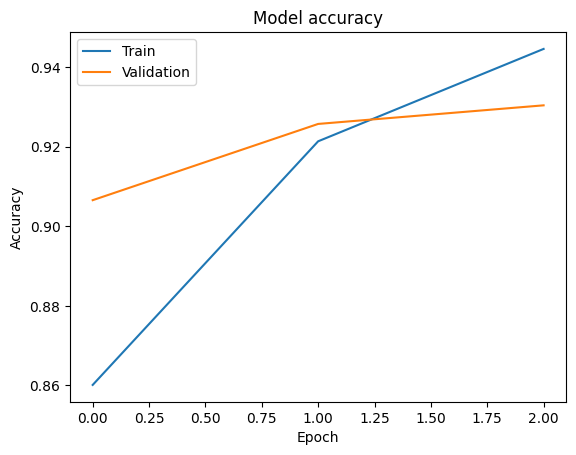

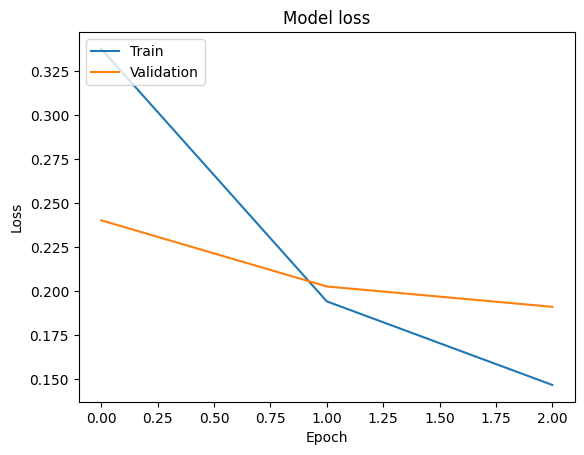

In [74]:

plt.plot(history6.history['accuracy'])
plt.plot(history6.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history6.history['loss'])
plt.plot(history6.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [75]:
predictions = classifier6.predict({
    'input_ids': input_ids,
    'token_type_ids': token_type_ids,
    'attention_mask': attention_mask
})

pred_labels = predictions > 0.5  

accuracy = accuracy_score(true_labels_numeric, pred_labels)
precision = precision_score(true_labels_numeric, pred_labels)
recall = recall_score(true_labels_numeric, pred_labels)
f1 = f1_score(true_labels_numeric, pred_labels)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

67/67 [==============================] - 82s 915ms/step
Accuracy: 0.9242990654205607
Precision: 0.9179755671902269
Recall: 0.9392857142857143
F1 Score: 0.9285083848190644


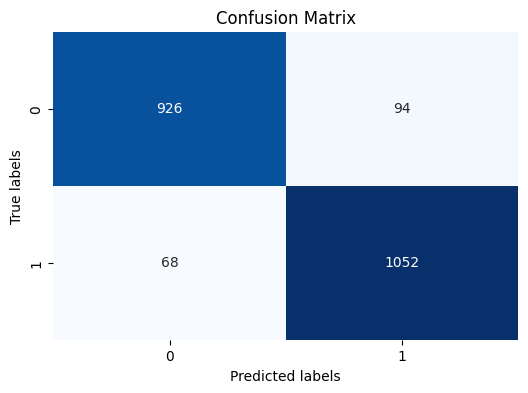

In [76]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels_numeric, pred_labels)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [22]:

custom_objects = {'BERTForClassificationBIGRU': BERTForClassificationBIGRU}

BIGRU128FreezeCT_classifier = tf.keras.models.load_model('/kaggle/working/BIGRU128FreezeCT', custom_objects=custom_objects)


In [23]:
import pandas as pd

tokenized_texts = tokenizer(list(data['preprocessed_tweet']), padding=True, truncation=True, max_length=128, return_tensors='tf')

input_ids = tf.convert_to_tensor(tokenized_texts['input_ids'])
attention_mask = tf.convert_to_tensor(tokenized_texts['attention_mask'])
token_type_ids = tf.convert_to_tensor(tokenized_texts['token_type_ids'])

predictions = BIGRU128FreezeCT_classifier.predict({
    'input_ids': input_ids,
    'token_type_ids': token_type_ids,
    'attention_mask': attention_mask
})
pred_labels = (predictions > 0.5).astype(int).flatten()  
results_df = pd.DataFrame({
    'Tweet': data['tweet'],
    'True Label': true_labels_numeric,
    'Predicted Label': pred_labels
})

wrong_predictions_df = results_df[results_df['True Label'] != results_df['Predicted Label']]

print(wrong_predictions_df.head(2))


67/67 [==============================] - 62s 884ms/step
                                                Tweet  True Label  \
10  Two interesting correlations:\n\n1) Children t...           0   
16  Households should have "required" medical kits...           0   

    Predicted Label  
10                1  
16                1  


In [24]:
wrong_predictions_df.to_csv('/kaggle/working/wrong_BIGRU128FreezeCT.csv', index=False)
